In [1]:
import json
import os.path
import sqlite3

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# test image:
version = 1
# train image:
#version = 2
params_path = f'results/prior_variance_experiment/custom_butterfly_prior/version_{version}/params.json'

In [3]:
with open(params_path, 'r') as fp:
        params_dict = json.load(fp)
value_db_path = os.path.join(params_dict['result_dir'], 'values.db')

In [4]:
connection = sqlite3.connect(value_db_path)
cursor = connection.cursor()

In [5]:
#view for variance data
cursor.execute("DROP VIEW IF EXISTS variance_data")
cursor.execute("CREATE view IF NOT EXISTS variance_data as SELECT AVG(prior_val), MIN(prior_val), MAX(prior_val), prior_samples from prior_variance_experiment group by prior_samples ")
cursor.execute("DROP VIEW IF EXISTS scatter_data")
cursor.execute("CREATE view scatter_data as SELECT prior_samples, prior_val from prior_variance_experiment")
cursor.execute("DROP VIEW IF EXISTS execution_times")
cursor.execute("CREATE view execution_times as SELECT AVG(end_time - start_time) as avg_execution_time, prior_samples from prior_variance_experiment group by prior_samples ")
connection.commit()

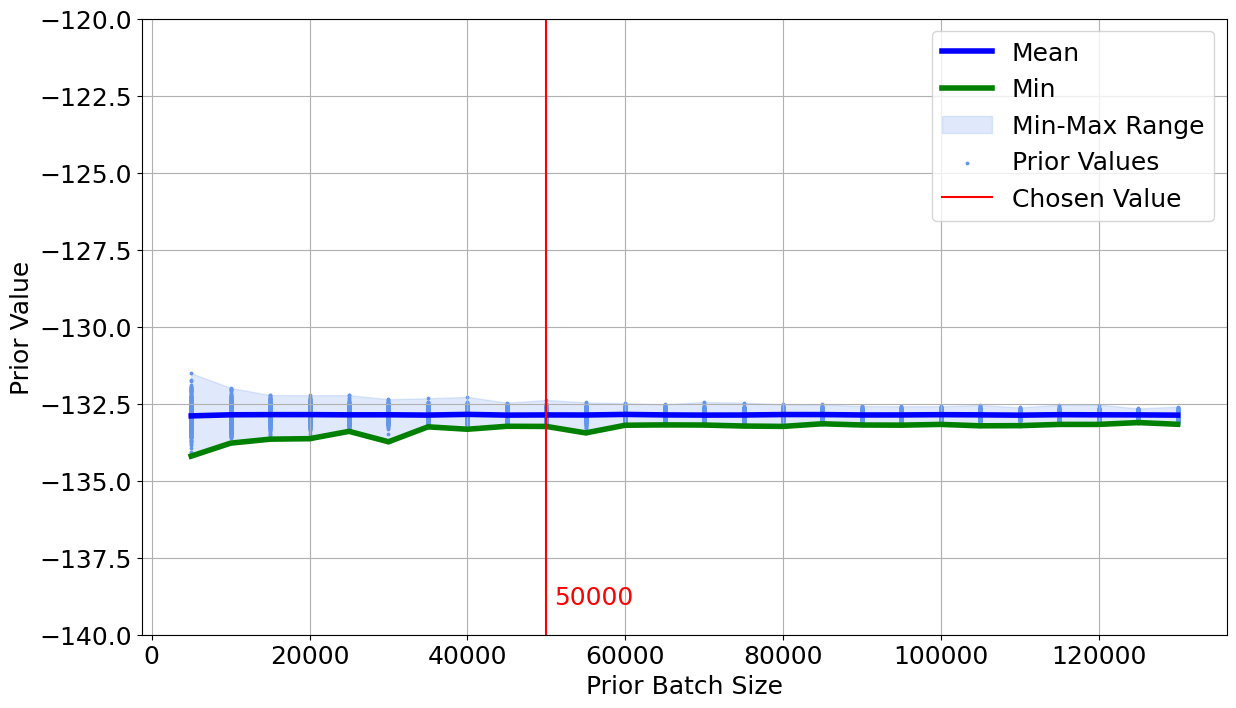

In [8]:
cursor.execute("SELECT * from variance_data")
means, mins, maxes, steps = zip(*cursor.fetchall())
cursor.execute("SELECT * from scatter_data")
scatter_steps, scatter_values = zip(*cursor.fetchall())
plt.rcParams.update({'font.size' : 18})
plt.figure(figsize=(14, 8))
plt.plot(steps, means, label='Mean', linestyle='-', linewidth=4, color='blue')
plt.plot(steps, mins, label='Min', linestyle='-', linewidth=4, color='green')
plt.fill_between(steps, mins, maxes, color='cornflowerblue', alpha=0.2, label='Min-Max Range')
plt.scatter(scatter_steps, scatter_values, color='cornflowerblue', marker='o', s=3, label='Prior Values')
plt.axvline(50000, label='Chosen Value', color='red')
plt.text(51000, -139, '50000', color='red')
ax = plt.gca()
ax.set_ylim([-140, -120])
plt.xlabel('Prior Batch Size')
plt.ylabel('Prior Value')
#plt.title('Prior value behavior for increasing batch sizes')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
cursor.execute('SELECT (AVG(prior_val)-AVG(prior_val)) as mean, (MIN(prior_val)-AVG(prior_val)) as min, (MAX(prior_val)-AVG(prior_val)) as max, prior_samples from prior_variance_experiment group by prior_samples')
norm_mean, norm_mins, norm_maxes, batch_size = zip(*cursor.fetchall())

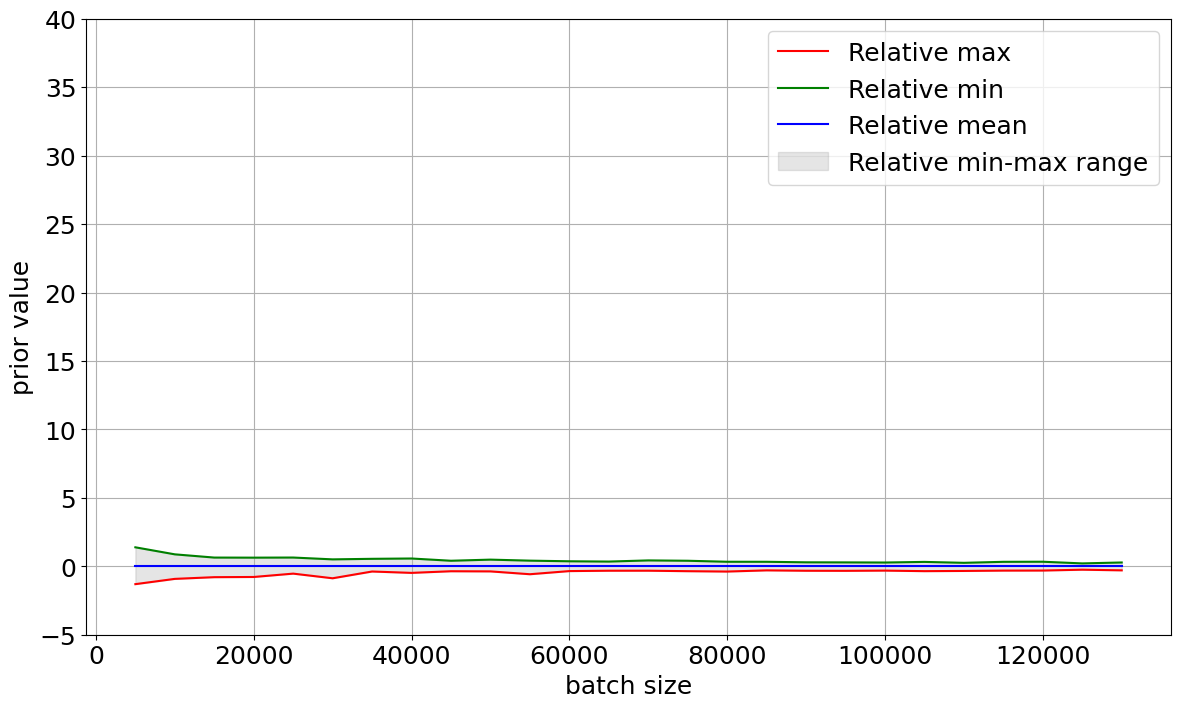

In [10]:
plt.figure(figsize=(14, 8))
#plt.plot(steps, means, label='Mean', linestyle='-', linewidth=4, color='blue')
plt.plot(batch_size, norm_mins, color='red', label='Relative max')
plt.plot(batch_size, norm_maxes, color='green', label='Relative min')
plt.plot(batch_size, norm_mean, color='blue', label='Relative mean')
plt.fill_between(batch_size, norm_mins, norm_maxes, color='gray', alpha=0.2, label='Relative min-max range')
#plt.scatter(scatter_steps, scatter_values, color='cornflowerblue', marker='o', s=3, label='Relative Prior values')
ax = plt.gca()
ax.set_ylim([-5, 40])
plt.legend()
plt.xlabel('batch size')
plt.ylabel('prior value')
#plt.title('Prior value behavior for increasing batch sizes')
plt.grid(True)
plt.show()

In [11]:
cursor.execute("SELECT * from execution_times")
avg_execution_time, batch_size = zip(*cursor.fetchall())

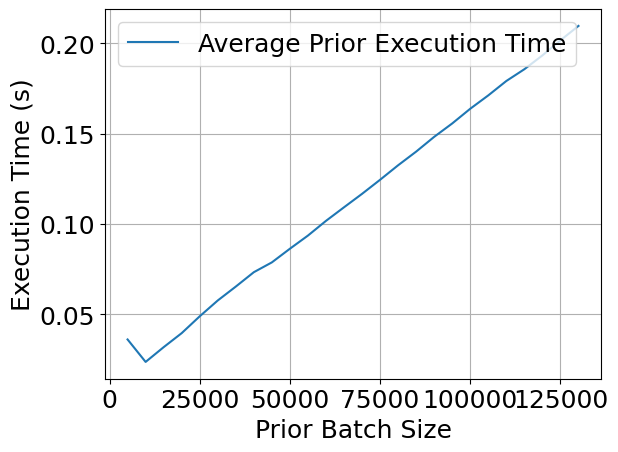

In [12]:
plt.plot(batch_size, avg_execution_time, label='Average Prior Execution Time')
plt.legend()
plt.xlabel('Prior Batch Size')
plt.ylabel('Execution Time (s)')
plt.grid(True)

In [13]:
normalized_maxes = (maxes - np.min(maxes))/np.ptp(maxes)
exec_norm = (avg_execution_time - np.min(avg_execution_time))/ np.ptp(avg_execution_time)

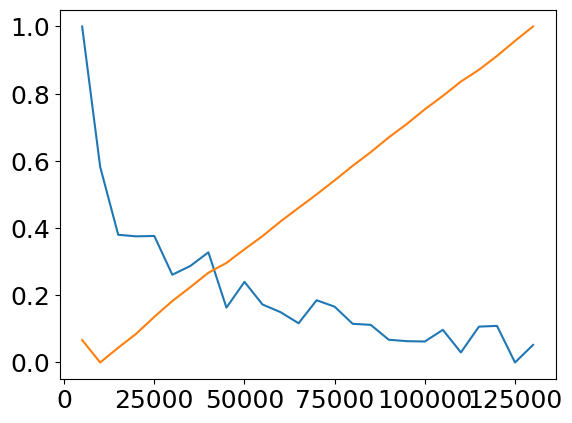

In [14]:
plt.plot(batch_size, normalized_maxes)
plt.plot(batch_size, exec_norm)

In [129]:
batch_size[np.argwhere(np.diff(np.sign(normalized_maxes - exec_norm))).flatten()[0]]

40000